In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
"""     ====>     initial parameters     <====     """
'''QDS'''
n = 24   #number of QDs [no unit]
R = 5.36290830288e-07   #radius of QD setup [m]
diam = 20e-9    #diameter of QD (atm made up)[m]
ts = 30e-9 #double quoted 15ns, time spent stopped between steps, time needed to discharge and charge quantum dot [s]
'''Permanent Charges'''
p = 12   #number of permanent charges (PCs) [no unit]
Rp = 5.36290830288e-07 - 110e-9   #radius of rotating disc [m]
r = Rp/3    #length of the cog shaft [m]
thc = 30e-9   #approximate thickeness of inner disc [m]
ro = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
vol = 1   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
cd = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
'''Other constants'''
eps = 8.854e-12 #currently set to epsilon 0 [F/m]
k = 1/(4*math.pi*eps)
e = 1.60217662e-19 # [C]
r0 = R - Rp   #distance between roatating disc and centre of QD setup above [m]
eta = 1.81e-5    #shear viscosity
beta = 0 #bulk viscoisty

In [17]:
def intertia( ro, thc, Rp):
    """Calculates inertia of inner rotating disk"""
    I = 0.5 * ro * math.pi * thc * ( Rp ** 4 )
    return I

In [18]:
def permanent_charge_magnitude( Rp, p , cd, vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (3*math.pi*(Rp**2))/(4*p) #see notebook for deriviation (not correct for capacitor arms)
    capacitance = cd * segment_area #capacitance of one segment
    stored_charge = capacitance * vol #stored charge in one segment
    return stored_charge

In [19]:
def permanent_charges( Rp, p , cd, vol):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( Rp, p , cd, vol)
        else:
            p_ch = -permanent_charge_magnitude( Rp, p , cd, vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

In [20]:
def quantum_dots( n, e):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, 24, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = 2*e
        elif i in range(3,24,4):
            q_ch = -2*e
        else:
            q_ch = 0
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [21]:
def tangential_component(n, e, R, r0, gamma):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n,e) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge
        F_c += k*PCs[0][3]*Q[3]/(ri**2) #coulomb force between permanent charge and QD
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        if (((r0**2)+(ri**2)-(d**2))/(2*r0*ri)) > 1 or (((r0**2)+(ri**2)-(d**2))/(2*r0*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos(((r0**2)+(ri**2)-(d**2))/(2*r0*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha
        F_t += F_c*math.sin(alpha)
    return F_t

In [22]:
def torque (F_t, Rp, p):
    """Computes torque on enitre inner rotor"""
    torque = F_t * Rp * p
    return torque

In [23]:
def angular_velocity(angle_increment, v_ang, i, torque, inertia):
    """Calculates the angular velocity after rotating the angle increment"""
    w_f = 0
    w_f = math.sqrt( (v_ang[i])**2 + (2*torque*angle_increment)/inertia )
    return w_f

In [24]:
def time_step(inertia, torque, v_ang):
    """Calculates time taken to reach new v_ang"""
    tau = (v_ang[i] - v_ang[i-1])* inertia/torque
    return tau

In [25]:
def viscous_force(n, eta, beta, Rp, r, v_ang, angle_increment, thc, i): #need to update in real time
    """Determines viscous force acing on rotor"""
    Dw = 0
    F_v = 0
    constant = (n/2) * ( math.log((Rp/(Rp-r))**2) + ((4*eta)/(3*Rp) + beta*(r))*thc )
    #print ( "constant=" , constant )
    if i < 1:
        Dw = 0
    else:
        Dw = (v_ang[i] - v_ang[i-1])/(angle_increment)
    F_v = constant * Dw 
    return F_v

4.6906526224706005e-07
13395119.640878858


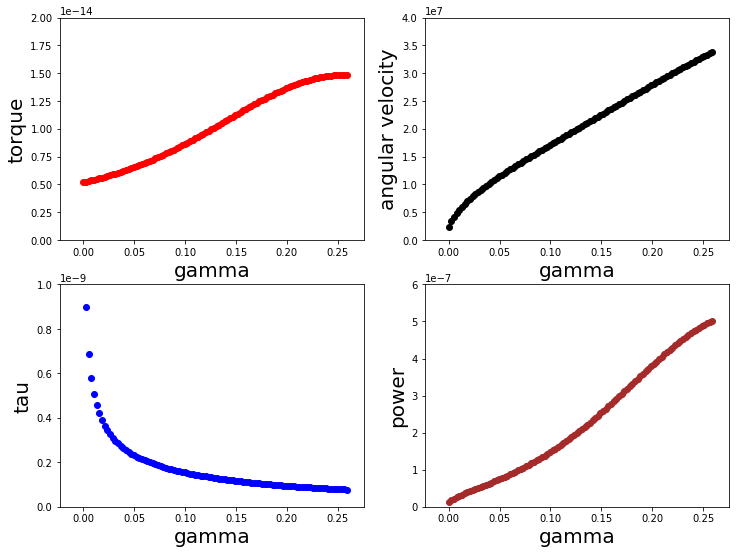

In [26]:
"""Main function"""
time = 0
step = math.pi*(360/24)/180 #angle between each QD, angle required for one step
angle_increment = step/100
PCs = permanent_charges( Rp, p , cd, vol) #initializes permanent charges

"""Graphs of output results of interest"""
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_xlabel('gamma', fontsize = '20')
ax1.set_ylabel('torque', fontsize = '20')
ax1.set_ylim( 0 , 2e-14)
ax2.set_xlabel('gamma', fontsize = '20')
ax2.set_ylabel('angular velocity', fontsize = '20')
ax2.set_ylim(0, 4e7)
ax3.set_xlabel('gamma', fontsize = '20')
ax3.set_ylabel('tau', fontsize = '20')
ax3.set_ylim(0, 1e-9)
ax4.set_xlabel('gamma', fontsize = '20')
ax4.set_ylabel('power', fontsize = '20')
ax4.set_ylim(0, 6e-7)

"""Computation"""
v_ang = [] #angular velocity
v_a = 0
v_ang.append( 0 ) #starting angluar velocity is 0
i=0
T=0
I = intertia( ro, thc, Rp)
for gamma in np.arange(0, step, angle_increment): #iterates angle increment until one step is completed
    #F_t = tangential_component(n, e, R, r0, gamma) - viscous_force(n, eta, beta, Rp, r, v_ang, angle_increment, thc, i) #resultant tangential force
    F_t = tangential_component(n, e, R, r0, gamma)
    T = torque(F_t, Rp, p) #calculates torque acting on inner rotor
    #print ( "torque=" , T )
    ax1.scatter(gamma, T , color = 'r') #plots torque vs angle rotated
    v_a = angular_velocity(angle_increment, v_ang, i, T, I) #calculates angular velocity after rotating by angle increment
    #print ( "v_ang=" , v_a )
    v_ang.append( v_a )
    i += 1 #needed to keep track of v_ang
    ax2.scatter(gamma, v_a, color = 'k') #plots angular velocity vs angle rotated
    tau = time_step( I, T, v_ang ) #calculates time taken to rotate angle
    ax3.scatter(gamma, tau, color = 'b') #plots time taken vs angle rotated
    ax4.scatter(gamma, (v_a * T), color = 'brown') #plots power vs angle rotated
    time += tau #total time taken
print (time * 24)
print ((2 * math.pi)/(time * 24))
plt.show()